# Time Series in Python
# Practical approach
# Homework task

Автор: Сергеев Дмитрий

https://github.com/DmitrySerg

In [1]:
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns                            # еще графики

from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # всякая статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings('ignore')

%matplotlib inline



from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

C:\Users\skulivec\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


В этой домашней работе вам предстоит поработать с двумя временными рядами, один - уже знакомый ряд с тратой внутриигровой валюты `currency`, второй - установки по дням в одном из наших приложений, `installs`

In [313]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # а имея доверительные интервалы, можно искать аномальные значения
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [2]:
currency = pd.read_csv('data/currency.csv', index_col=['Time'], parse_dates=['Time'])
installs = pd.read_csv('data/installs.csv', index_col=['Time'], parse_dates=['Time'])

Снова посмотрим на графики временных рядов

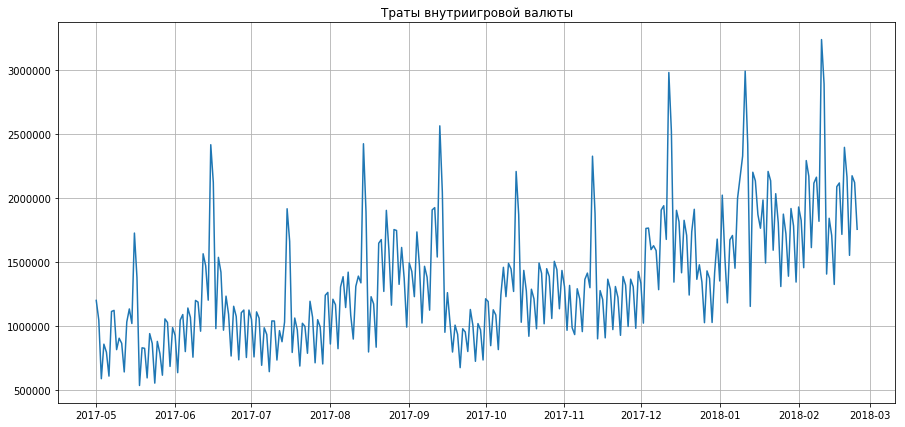

In [3]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Траты внутриигровой валюты')
plt.grid(True)
plt.show()

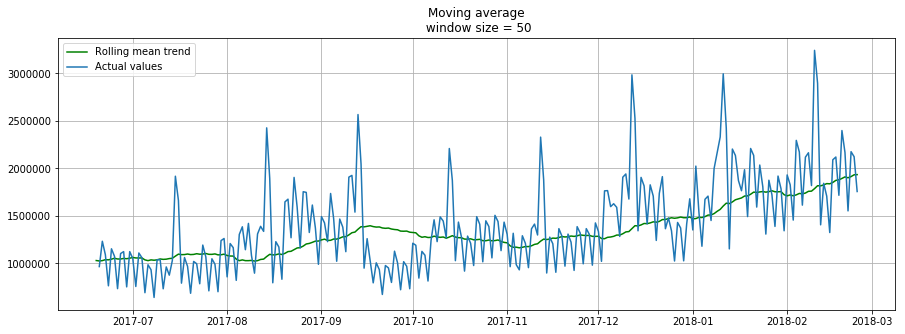

In [323]:
plotMovingAverage(currency.GEMS_GEMS_SPENT, 50)

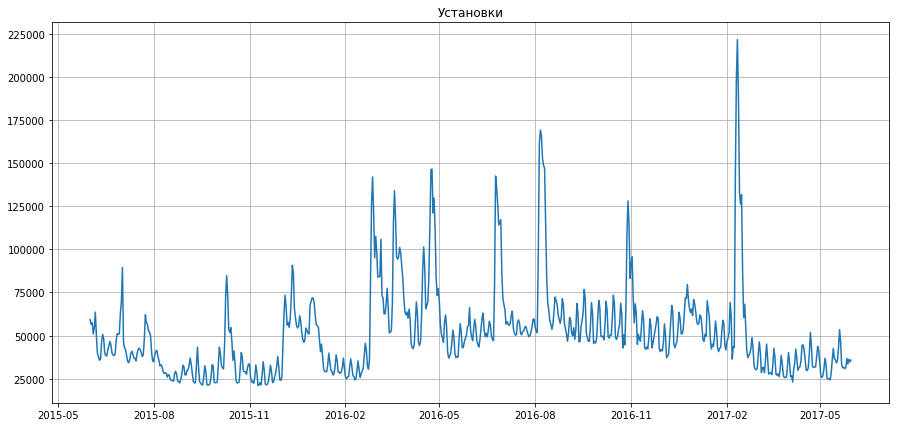

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(installs)
plt.title('Установки')
plt.grid(True)
plt.show()

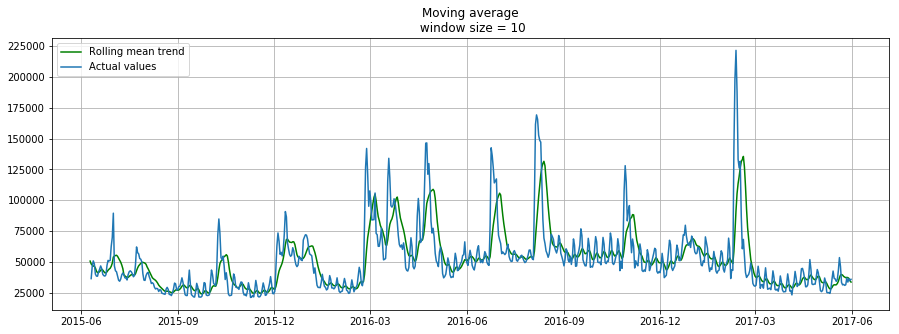

In [319]:
plotMovingAverage(installs, 10)

У первого временного ряда явно есть и сезонность, и тренд, а вот второй ряд с установками имеет очень много выбросов, которые никак не характеризуются сезонными изменениями.

Для начала поработаем с моделью тройного экспоненциального сглаживания - моделью Хольта-Винтерса

In [5]:
from sklearn.model_selection import TimeSeriesSplit 
from HoltWinters import HoltWinters                 

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # вектор ошибок
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

def plotHoltWinters(series, line_border, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    intervals = len(series)
    
    plt.figure(figsize=(20, 10))
    
    plt.plot(model.result[-intervals:], label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values[line_border:], model.result[-intervals:][line_border:])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[-intervals:][:len(series)]] = \
            series.values[series.values<model.LowerBond[-intervals:][:len(series)]]
        anomalies[series.values>model.UpperBond[-intervals:][:len(series)]] = \
            series.values[series.values>model.UpperBond[-intervals:][:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond[-intervals:], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond[-intervals:], "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result[-intervals:])), y1=model.UpperBond[-intervals:], 
                         y2=model.LowerBond[-intervals:], alpha=0.2, color = "grey")    
        
    plt.vlines(line_border, ymin=min(model.LowerBond[-intervals:]), ymax=max(model.UpperBond[-intervals:]), linestyles='dashed')
    plt.axvspan(line_border, len(model.result[-intervals:]), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

Задание:

- Построить модель для временного ряда с установками, используя `mean_squared_error` в качестве функции потерь
- Сначала постройте модель на всём ряду installs.Users, отложив только последние 50 наблюдений для тестирования, убедитесь, что прогноз по такой модели будет сильно заниженным
- Теперь возьмите для моделирования только последние 500 наблюдений, для этого возьмите от временного ряда срез [500:-50], чтобы учесть в модели только последние изменения и не пытаться подогнать параметры под историю, которая уже стала нерелевантной

In [6]:
%%time
data = installs.Users[:-50] # отложим 50 наблюдений для тестирования
slen = 7 # недельная сезонность
# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем квадратичную функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, 
                     mean_squared_error, 
                     slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.14958909808889503 0.02648771746164602 0.1278615041821196
Wall time: 21.8 s


In [7]:
installs.Users[500:].shape, len(installs.Users[500:])-50

((231,), 181)

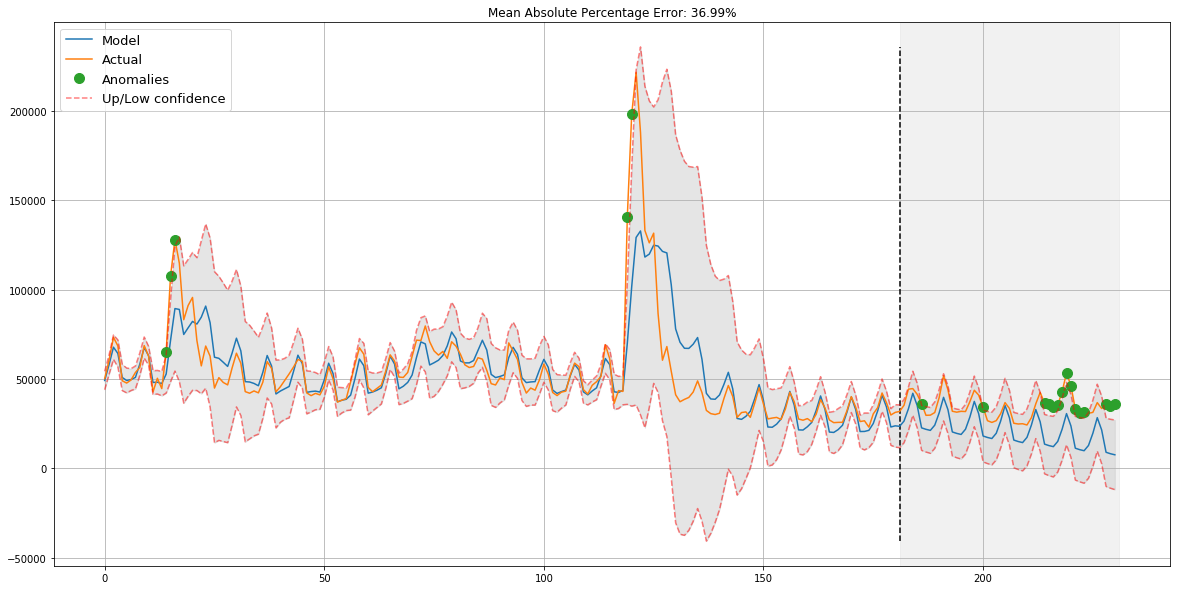

In [8]:
plotHoltWinters(installs.Users[500:], line_border=len(installs.Users[500:])-50, plot_intervals=True, plot_anomalies=True)

А теперь обрежем наши данные, чтобы обучаться на последнем промежутке времени, наиболее релевантным для сегодняшних значений

In [9]:
%%time
data = installs.Users[500:-50] 
slen = 7
x = [0, 0, 0] 

# Минимизируем квадратичную функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, 
                     mean_squared_error, 
                     slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.2618820126194623 0.022218824066198406 0.020541629867251943
Wall time: 5.77 s


Прекрасно! Мы снова можем ловить аномалии, а модель неплохо описывает поведение нашего временного ряда и строит правдоподобный прогноз

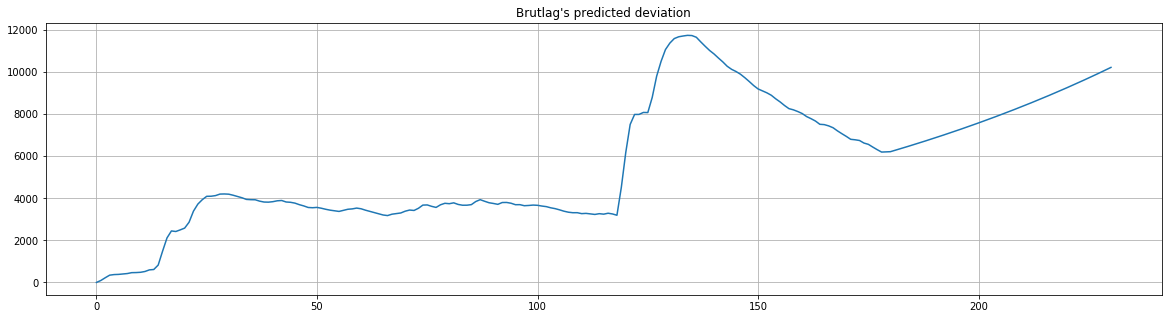

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

По графику смоделированной дисперсии легко увидеть, как выброс в наших данных значительно увеличил отклонение и вызвал расширение доверительных интерваловна некоторых промежуток времени

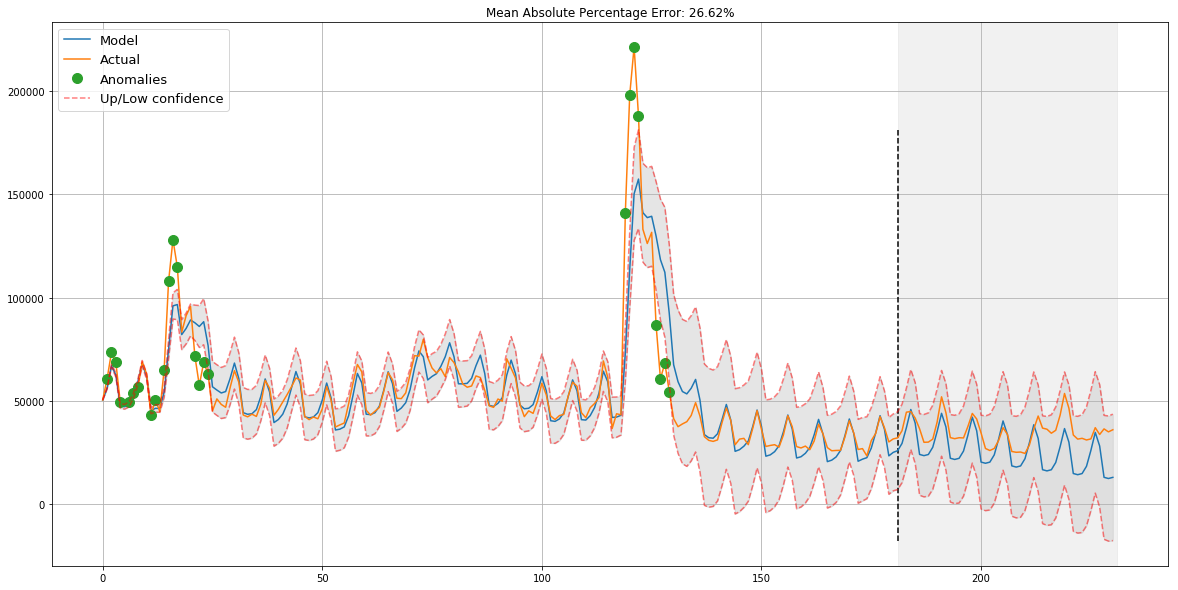

In [11]:
plotHoltWinters(installs.Users[500:], line_border=len(installs.Users[500:])-50, plot_intervals=True, plot_anomalies=True)

# Эконометрический подход

In [12]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()

In [22]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            print(param)
            model=sm.tsa.statespace.SARIMAX(ads_Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except ValueError:
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортируем по возрастанию, чем меньше критерий AIC, тем лучше
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

В качестве домашнего задания и хорошей практики для закрепления - по аналогии с лекцией построить модель SARIMA для прогнозирования временного ряда с тратой внутриигровой валюты, в котором присутствует тренд (убирается при помощи первых разностей) и месячная сезонность (сезонное дифференцирование с периодом 30)

Критерий Дики-Фуллера: p=0.372542


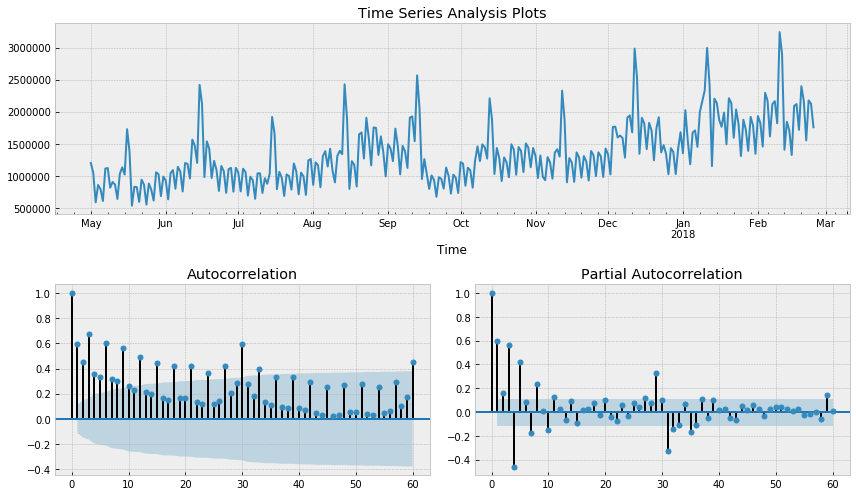

In [15]:
tsplot(currency.GEMS_GEMS_SPENT, lags=60)

# TODO
# - привести ряд к стационарному виду
# - по ACF, PACF определить начальные значения параметров модели и возможные интервалы
# - перебором параметров подобрать оптимальную модель и построить её
# - построить график модельных значений и остатков, убедиться в адекватности результатов

Критерий Дики-Фуллера: p=0.000655


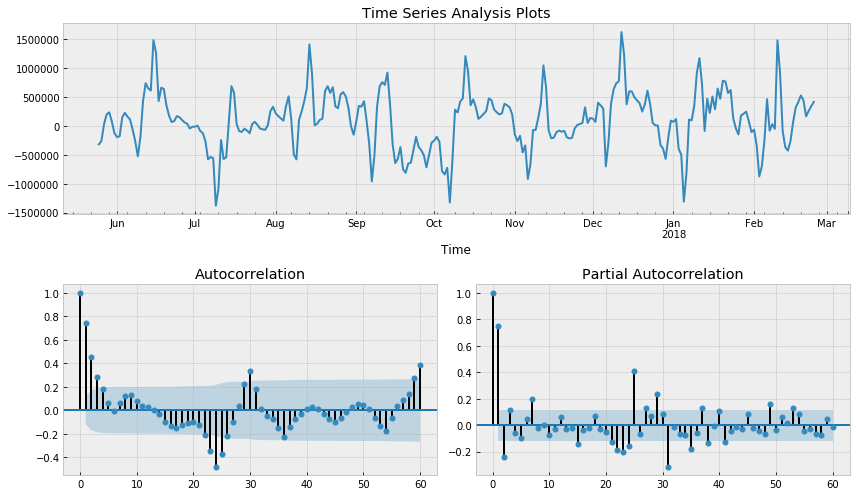

In [16]:
currency_diff = currency.GEMS_GEMS_SPENT - currency.GEMS_GEMS_SPENT.shift(24)
tsplot(currency_diff[24:], lags=60)

Критерий Дики-Фуллера: p=0.000000


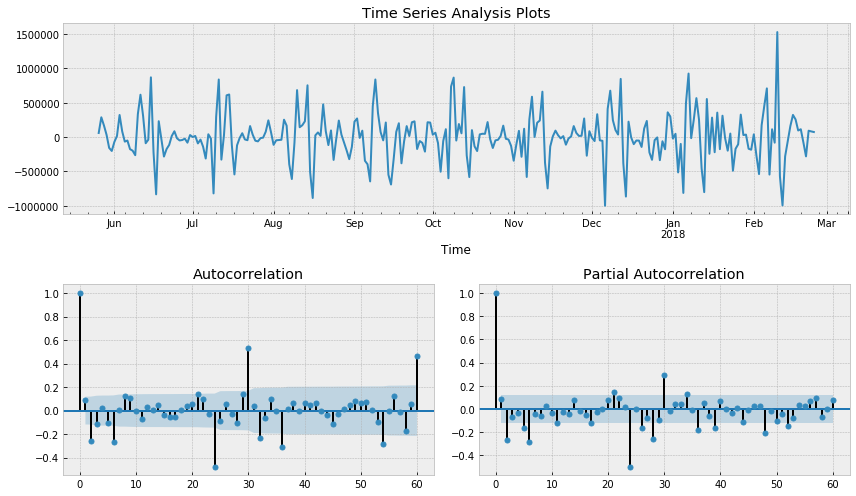

In [17]:
currency_diff = currency_diff - currency_diff.shift(1)
tsplot(currency_diff[24+1:], lags=60)

In [18]:
# p = 6 (21)
# d = 1
# q = 7 

# P = 2
# D = 1
# Q = 1
# s = 24

In [25]:
# зададим ограничения на возможные значения параметров для перебора
ps = range(5, 7)
d= 1
qs = range(6, 8)

Ps = range(1, 3)
D= 1
Qs = range(0, 2)
s = 24

# создадим лист с возможными параметрами и посчитаем его длину
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [31]:
%%time
ads_Ads = currency.GEMS_GEMS_SPENT[:-50] 
result_table = optimizeSARIMA(parameters_list, d, D, s)

HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

(5, 6, 1, 0)
(5, 6, 1, 1)
(5, 6, 2, 0)
(5, 6, 2, 1)
(5, 7, 1, 0)
(5, 7, 1, 1)
(5, 7, 2, 0)
(5, 7, 2, 1)
(6, 6, 1, 0)
(6, 6, 1, 1)
(6, 6, 2, 0)
(6, 6, 2, 1)
(6, 7, 1, 0)
(6, 7, 1, 1)
(6, 7, 2, 0)
(6, 7, 2, 1)
Wall time: 2min 5s


In [139]:
(p, d, q), (P, D, Q, s)

((5, 1, 6), (1, 1, 1, 24))

In [32]:
# передаём параметры с минимальным AIC
p, q, P, Q = result_table.parameters[0]

# обучаем лучшую модель
best_model=sm.tsa.statespace.SARIMAX(ads_Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    GEMS_GEMS_SPENT   No. Observations:                  250
Model:             SARIMAX(5, 1, 6)x(1, 1, 1, 24)   Log Likelihood               -3092.898
Date:                            Fri, 01 Jun 2018   AIC                           6213.797
Time:                                    14:10:56   BIC                           6263.097
Sample:                                05-01-2017   HQIC                          6233.639
                                     - 01-05-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3178      0.900      0.353      0.724      -1.446       2.081
ar.L2         -0.8276      1.060   

Критерий Дики-Фуллера: p=0.000000


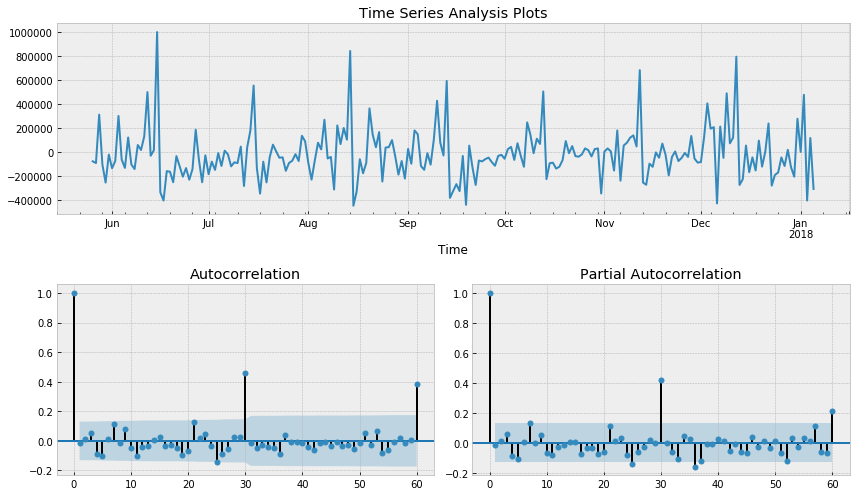

In [33]:
tsplot(best_model.resid[24+1:], lags=60)

In [99]:
len(best_model.fittedvalues), len(currency[:-50])

(250, 250)

In [137]:
def plotSARIMA(series, model, n_steps, start_pos):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # подставляем модельные значения
    data = series[:-n_steps].copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # делаем отступ на s+d, так как эти значения в модели были ненаблюдаемыми
    # из-за дифференцирования
    #data['arima_model'][:s+d] = np.NaN
    
    # прогнозируем на n_steps шагов вперёд     
    forecast = model.predict(start = start_pos, end = start_pos+n_steps-1) #data.shape[0], end = data.shape[0]+n_steps) 
        
    forecast = data.arima_model.append(forecast)
        
    data.loc[start_pos:start_pos+n_steps,'actual'] = series[-n_steps:]
    
    # считаем ошибку, также отступив s+d шагов от начала
        
    error = mean_absolute_percentage_error(currency.GEMS_GEMS_SPENT[start_pos:], forecast[start_pos:])
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(series.index[start_pos], series.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(series, label="actual")
    plt.legend()
    plt.grid(True);
    return forecast

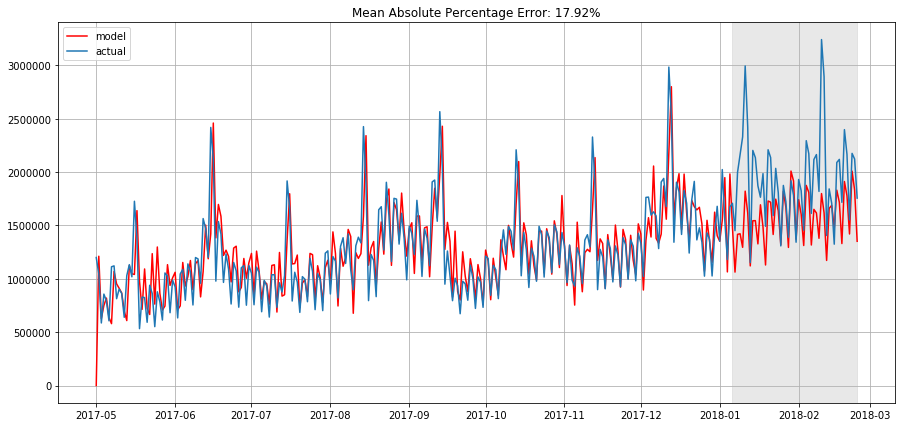

In [138]:
data = plotSARIMA(currency, best_model, 50, len(currency[:-50]))

In [98]:
len(best_model.predict(start = 250, end = 250+50)), len(currency[:-50])

(51, 250)

# Machine Learning для временных рядов

In [140]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from 

scaler = StandardScaler()
# для рассчета ошибки на кросс-валидации будем бить ряд на 5 фолдов
tscv = TimeSeriesSplit(n_splits=5)

In [141]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(X)*(1-test_size))
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [291]:
def plotModelResults(model, X_train, X_test, y_train, y_test, plot_intervals=False, plot_anomalies=False, 
                     trend_train=0, trend_test=0):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза и аномалий
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(X_test) + trend_test
    y_test = y_test + trend_test
    
    #y_train = y_train + trend_train
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [144]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [158]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по часу, дню недели и выходным
    data.index = data.index.to_datetime()
    
    data["day"] = data.index.day
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["day_average"] = list(map(code_mean(data[:test_index], 'day', "y").get, data.day))

        # выкидываем закодированные средними признаки 
        data.drop(["day", "weekday"], axis=1, inplace=True)
    
    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

Снова небольшим домашним заданием будет построение моделей для временного ряда с внутриигровой валютой.

TODO

- Изменить функцию `prepareData` так, чтобы она не извлекала признак "час" и "среднее по часу", а вместо этого добавить извлечение признака "день месяца" и "среднее по дню месяца"
- Подготовить данные для построения модели, взяв `lag_start = 7`, чтобы модель могла прогнозировать на неделю вперед, а `lag_end = 31`, чтобы месячная сезонность также попала в наблюдаемые моделью значения
- Построить линейную модель с `target_encoding` (среднее по дню месяца) и без, проверить, что лучше
- Построить ридж и лассо регрессии, посмотреть, какие факторы модели считают наиболее важными
- Забустить этот временной ряд и убедиться, что по умолчанию `xgb` будет давать отвратительный результат

In [302]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test =\
prepareData(currency.GEMS_GEMS_SPENT, lag_start=7, lag_end=31, test_size=0.17, target_encoding=True)

lmodel = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('scaller', StandardScaler()),
    ('clf', LinearRegression(n_jobs=-1))
])

lmodel.fit(X_train, y_train)
y_hat = lmodel.predict(X_test)
print("With target_encoding")
print("Mean Absolute Percentage Error: {0:.2f}%".format(mean_absolute_percentage_error(y_test, y_hat)))

With target_encoding
Mean Absolute Percentage Error: 15.48%


In [303]:
X_train, X_test, y_train, y_test =\
prepareData(currency.GEMS_GEMS_SPENT, lag_start=7, lag_end=31, test_size=0.17, target_encoding=False)

lmodel = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('scaller', StandardScaler()),
    ('clf', LinearRegression(n_jobs=-1))
])

lmodel.fit(X_train, y_train)
y_hat = lmodel.predict(X_test)
print("Without target_encoding")
print("Mean Absolute Percentage Error: {0:.2f}%".format(mean_absolute_percentage_error(y_test, y_hat)))

Without target_encoding
Mean Absolute Percentage Error: 13.96%


In [304]:
from sklearn.linear_model import Lasso

lmodel = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('scaller', StandardScaler()),
    ('clf', Lasso(alpha=1.5)),   
])

lmodel.fit(X_train, y_train)
y_hat = lmodel.predict(X_test)
print("LASSO linear model")
print("Mean Absolute Percentage Error: {0:.2f}%".format(mean_absolute_percentage_error(y_test, y_hat)))
print(pd.DataFrame(lmodel.named_steps['clf'].coef_, X_train.columns).sort_values(0))

LASSO linear model
Mean Absolute Percentage Error: 13.96%
                        0
day        -109477.653965
lag_22      -65682.124857
lag_20      -48986.569921
lag_24      -46252.274486
lag_8       -44463.936049
lag_16      -35550.750991
weekday     -34321.665192
lag_10      -26013.294845
lag_25      -24588.251485
lag_26      -23777.984913
lag_28      -18833.059871
lag_27      -12032.235755
lag_18       -8422.543114
lag_23       -7304.936767
lag_29       -6966.008294
lag_19        -502.860759
lag_12         317.559853
lag_13        8177.957371
lag_14       21952.243257
lag_17       34079.318676
lag_11       40134.347797
lag_21       41655.992432
lag_15       47594.207160
is_weekend   60040.647535
lag_9        83181.851753
lag_7       127801.483801
lag_30      246810.822535


In [305]:
from sklearn.linear_model import Ridge

lmodel = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('scaller', StandardScaler()),
    ('clf', Ridge(alpha=1.5))
])

lmodel.fit(X_train, y_train)
y_hat = lmodel.predict(X_test)
print("RIDGE linear model")
print("Mean Absolute Percentage Error: {0:.2f}%".format(mean_absolute_percentage_error(y_test, y_hat)))
print(pd.DataFrame(lmodel.named_steps['clf'].coef_, X_train.columns).sort_values(0))

RIDGE linear model
Mean Absolute Percentage Error: 13.77%
                        0
day        -107572.451287
lag_22      -53604.355810
lag_24      -36543.405527
lag_20      -36383.500665
lag_8       -33875.767491
weekday     -31447.291369
lag_25      -30576.082844
lag_16      -23305.653117
lag_26      -22199.842890
lag_28      -19910.830795
lag_23      -17788.110954
lag_10      -14302.799010
lag_19      -13513.003533
lag_27      -10585.505643
lag_29       -2171.564907
lag_13       -1344.152985
lag_18        5760.645895
lag_12       12018.021330
lag_17       19475.747815
lag_11       26911.225564
lag_14       30073.233174
lag_21       30335.955666
lag_15       37445.228231
is_weekend   57435.576291
lag_9        72517.594420
lag_7       121144.821104
lag_30      240914.259512


XGBRegressor без всего:


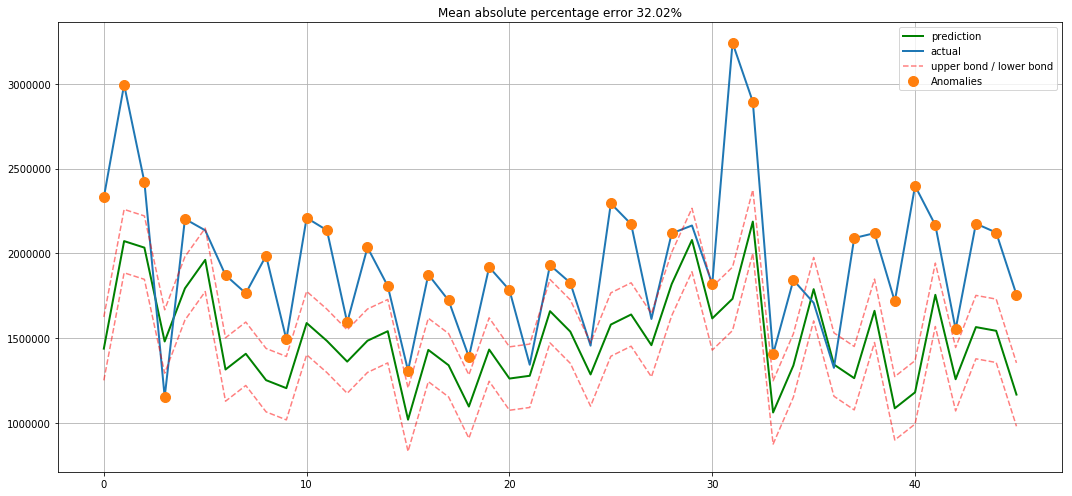

In [306]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

print("XGBRegressor без всего:")
plotModelResults(xgb, 
                 X_train=X_train, 
                 X_test=X_test,
                 y_train=y_train, 
                 y_test=y_test,
                 plot_intervals=True, plot_anomalies=True)

Крутое бонус-задание
- Разбейте подготовленные данные на `train` и `test`
- Очистите временной ряд от линейного тренда при помощи построения однофакторной линейной регрессии, где таргетом будут значения ряда, а фактором - числовой ряд от 0 до `len(train)`. Предсказанные по такой модели значения будут линейным трендом, который нужно вычесть из исходного ряда (подбробнее можно посмотреть [здесь](https://machinelearningmastery.com/time-series-trends-in-python/))
- Теперь спрогнозируйте значения тренда по этой модели для тестового датасета, для этого нужно в качестве фактора взять числовой ряд от `len(train)` до `len(test)`, очистите тестовый датасет от тренда при помощи этого прогноза
- Далее на очищенных от тренда данных `train` постройте xgboost и постройте прогноз на `test`
- Наконец, просуммируйте предсказанное значение тренда и прогнозы бустинга, чтобы получить красивый итоговый прогноз временного ряда

In [361]:
import numpy

X_train, X_test, y_train, y_test =\
prepareData(currency.GEMS_GEMS_SPENT, lag_start=7, lag_end=31, test_size=0.17, target_encoding=False)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


lmodel = LinearRegression(n_jobs=-1)

X = [i for i in range(0, len(y_train))]
X = numpy.reshape(X, (len(X), 1))

lmodel.fit(X, y_train)

X_t = [i for i in range(len(y_train), len(y_train)+len(y_test))]
X_t = numpy.reshape(X_t, (len(X_t), 1))

y_hat = lmodel.predict(X_t)

print("Without target_encoding")
print("Mean Absolute Percentage Error: {0:.2f}%".format(mean_absolute_percentage_error(y_test, y_hat)))

Without target_encoding
Mean Absolute Percentage Error: 20.42%


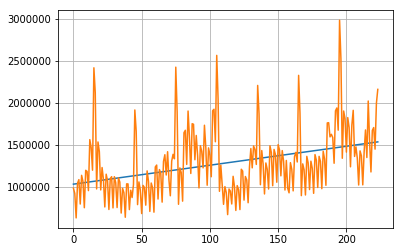

In [362]:
plt.plot(lmodel.predict(X))
plt.plot(y_train.values[X[:,0]])
plt.grid(True)

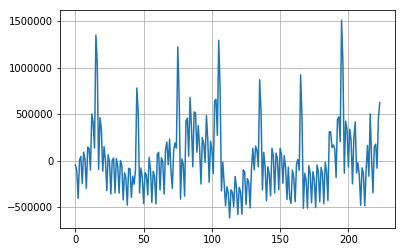

In [363]:
trend = lmodel.predict(X)
detrended = [y_train.values[i]-trend[i] for i in range(0, len(trend))]
plt.plot(detrended)
plt.grid(True)

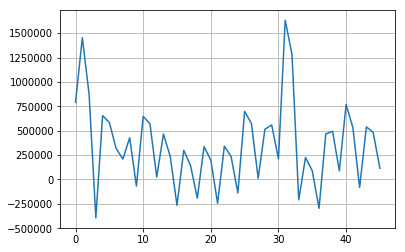

In [364]:
trend_t = lmodel.predict(X_t)
detrended_t = [y_test.values[i]-trend_t[i] for i in range(0, len(trend_t))]
plt.plot(detrended_t)
plt.grid(True)

In [365]:
detrended = pd.core.series.Series(detrended)
detrended_t = pd.core.series.Series(detrended_t)

XGBRegressor с учтённым трендом:


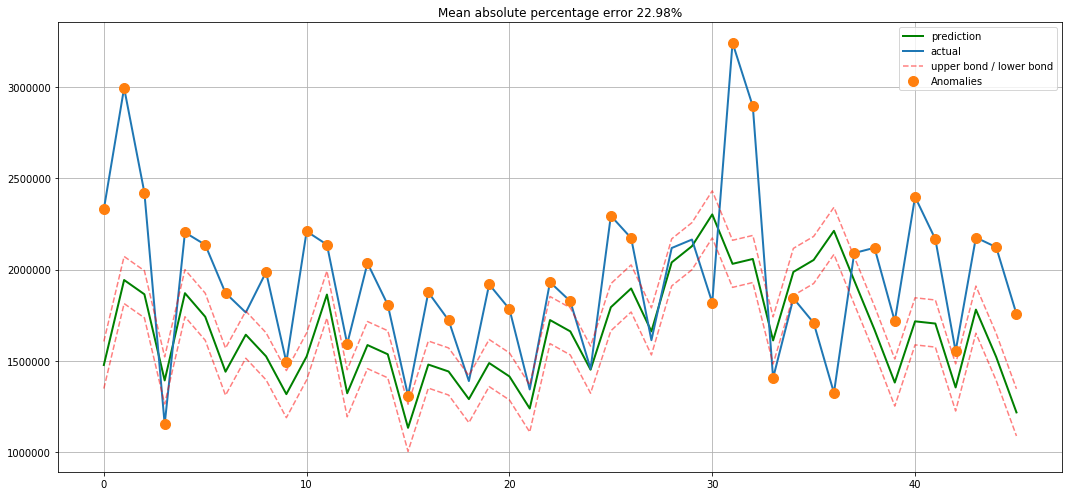

In [366]:
xgb = XGBRegressor()
#xgb.fit(X_train, detrended)
xgb.fit(X_train, detrended, 
eval_set=[(X_train, detrended), (X_test, detrended_t)], 
eval_metric='mae', 
early_stopping_rounds=10,
verbose=False)

print("XGBRegressor с учтённым трендом:")
plotModelResults(xgb, 
                 X_train=X_train, 
                 X_test=X_test,
                 y_train=detrended, 
                 y_test=detrended_t,
                 plot_intervals=True, plot_anomalies=True,
                 trend_train=lmodel.predict(X), trend_test=lmodel.predict(X_t) # доп.параметры - тренд
                )